## Compute Welfares

In [102]:
# Define the various scenarios
N = 100
experiments = [
    dict(name='cesds', param='delta', range=(0.2,0.3,N)),
    dict(name='ces', param='xi', range=(0.2,1.0,N)),
    dict(name='exponential', param='alpha', range=(1,10,N)),
    dict(name='translog', param='sigma', range=(1,10,N)),
    dict(name='cesds_EL1', param='varphi', range=(0.1,10,N)),
    dict(name='cesds_EL2', param='mu', range=(1.1,2,N)),
    dict(name='cesds_EI1', param='zeta', range=(0.3,0.9,N)),
    dict(name='cesds_EI2', param='mu', range=(1.1,2,N)),
    #dict(name='cesds_ELEI', param='sigma', range=(1,10,N))
    
]

In [103]:
def num_there(s):
    return any(i.isdigit() for i in s)


def compute_case(expm):
    '''Evaluates welfare for the planner and the competitive equilibrium for various values of a specified parameter.
    
    Parameters
    ----------
    expm: dict
        Description of the experiment to perform. Contains several fields:
        - name: name of the experiment, the corresponding model file is expected to be model_*name*.yaml
        - param: name of the parameter to change
        - range: set of parameter values (min value, max value, N values)
    Returns
    -------
    df: pandas.DataFrame
        Each line contains:
        - parameter value
        - welfare for the planner optimum
        - welfare for the competitive equilibrium
    '''
        
    
    import pandas
    from dolo import yaml_import
    from numpy import exp, array, linspace, column_stack
    from dolo.algos.perturbations_higher_order import perturbate
    from dolo.algos.simulations import tabulate
    from dolo.algos.steady_state import residuals
    from dolo.algos.steady_state import find_steady_state

    
    case = expm['name']
    param = expm['param']
    range = expm['range']
    
    # create parameter range
    parm_vec = linspace(*range)
        
    # import model and get discount rate
    if num_there(case) == True:
        model = yaml_import('model_{}.yaml'.format(case[:-1]))
    else:    
        model = yaml_import('model_{}.yaml'.format(case))
    beta = model.calibration['beta'];
    
    values_ce = []
    values_po = []
    
    # solve all calibrations
    for i in parm_vec:
        
        # Set calibrated parater value
        pp = {param:i}
        model.set_calibration(**pp)
        
        # Solve for the competitive equilibrium
        model.set_calibration(po=0);
        calib = find_steady_state(model);
        res = residuals(model,calib=calib)
        
        
        if abs(sum(res['arbitrage'])) + abs(sum(res['transition'])) > 0.00000001:
            print('model', case, 'ME', param, '=', i, '--> steady state cant be found: non-zero residuals')  
        #else:
            #model.calibration['controls'] = calib['controls']
            #model.calibration['states'] = calib['states']  
            
        dr_ce = perturbate(model, order=2, steady_state=calib);

        # Solve for the social planner equilibrium
        model.set_calibration(po=1);
        calib = find_steady_state(model);
        res = residuals(model,calib=calib)
        if abs(sum(res['arbitrage'])) + abs(sum(res['transition'])) > 0.00000001:
            print('model', case, 'PO', param, '=', i, '--> steady state cant be found: non-zero residuals')
        #else:
            #model.calibration['controls'] = calib['controls']
            #model.calibration['states'] = calib['states']         
        
        dr_po = perturbate(model, order=2, steady_state=calib);   
        
                    
            
        # Initial point at which to evaluate the welfare
        eval_point = calib['states'].copy();
        # Change initial value of N
        eval_point[1]*=0.5 # to 50 % of its of its steady-state value
#         eval_point[1]=1    # to 1

        # Evalueate welfare
        w_ce = dr_ce(eval_point)[1]
        w_po = dr_po(eval_point)[1]
        
        # Convert to consumption equivalent
        v_ce = exp((1-beta)*w_ce)
        v_po = exp((1-beta)*w_po)
        
        # Add to list of values
        values_ce.append(v_ce)
        values_po.append(v_po)
    
   
    # Construct dataframe
    columns = [h.format(case) for h in ['{}_'+param, '{}_po', '{}_ce']]
    df = pandas.DataFrame( column_stack([parm_vec, values_po, values_ce]), columns=columns)
    
    return df

In [104]:
# parrallel evaluation (needs 3 workers)
# from IPython.parallel import Client
# rc = Client()
# dviews = rc[:3]
# all_welfares = dviews.map_sync(compute_case, experiments)

In [105]:
# serial evaluation
all_welfares = [compute_case(exp) for exp in experiments]

In [106]:
# Add welfare gains to dataframe
import pandas
df = pandas.concat(all_welfares, axis=1)
# compute gains
for exp in experiments:
    case = exp['name']
    df['{}_gain'.format(case)] = (df['{}_po'.format(case)]/df['{}_ce'.format(case)]-1)*100
# save to Excel
df.to_excel('welfare_gains.xls')
df

,cesds_delta,cesds_po,cesds_ce,ces_xi,ces_po,ces_ce,exponential_alpha,exponential_po,exponential_ce,translog_sigma,...,cesds_EI2_po,cesds_EI2_ce,cesds_gain,ces_gain,exponential_gain,translog_gain,cesds_EL1_gain,cesds_EL2_gain,cesds_EI1_gain,cesds_EI2_gain
0,0.200000,0.743158,0.743158,0.200000,1.164338,1.132902,1.000000,0.690086,0.690057,1.000000,...,2.644814,2.638500,0.0,2.774874,0.004205,1.491220,45.236549,10.808267,38.409627,0.239319
1,0.201010,0.741523,0.741523,0.208081,1.180363,1.152177,1.090909,0.701558,0.701531,1.090909,...,2.700068,2.692477,0.0,2.446356,0.003825,1.429107,40.559606,11.790117,34.903416,0.281927
2,0.202020,0.739897,0.739897,0.216162,1.196922,1.171802,1.181818,0.711802,0.711777,1.181818,...,2.759223,2.750215,0.0,2.143748,0.003504,1.374235,36.775582,12.771936,31.848937,0.327555
3,0.203030,0.738280,0.738280,0.224242,1.214018,1.191783,1.272727,0.721024,0.721001,1.272727,...,2.822240,2.811665,0.0,1.865710,0.003231,1.325296,33.643197,13.753729,29.173331,0.376113
4,0.204040,0.736673,0.736673,0.232323,1.231654,1.212126,1.363636,0.729386,0.729365,1.363636,...,2.889109,2.876810,0.0,1.611014,0.002995,1.281290,31.005064,14.735503,26.817707,0.427517
5,0.205051,0.735075,0.735075,0.240404,1.249833,1.232838,1.454545,0.737016,0.736995,1.454545,...,2.959843,2.945654,0.0,1.378534,0.002789,1.241439,28.751803,15.717259,24.734055,0.481685
6,0.206061,0.733486,0.733486,0.248485,1.268562,1.253926,1.545455,0.744015,0.743996,1.545455,...,3.034480,3.018225,0.0,1.167237,0.002608,1.205128,26.804483,16.699001,22.882921,0.538540
7,0.207071,0.731906,0.731906,0.256566,1.287845,1.275395,1.636364,0.750467,0.750448,1.636364,...,3.113072,3.094566,0.0,0.976169,0.002448,1.171859,25.104543,17.680730,21.231651,0.598007
8,0.208081,0.730335,0.730335,0.264646,1.307689,1.297253,1.727273,0.756440,0.756423,1.727273,...,3.195689,3.174735,0.0,0.804452,0.002305,1.141230,23.607544,18.662449,19.753034,0.660016
9,0.209091,0.728773,0.728773,0.272727,1.328100,1.319507,1.818182,0.761992,0.761976,1.818182,...,3.282414,3.258804,0.0,0.651272,0.002177,1.112908,22.279129,19.644156,18.424258,0.724498


## Make plots

In [108]:
from matplotlib import pyplot as plt
%matplotlib inline

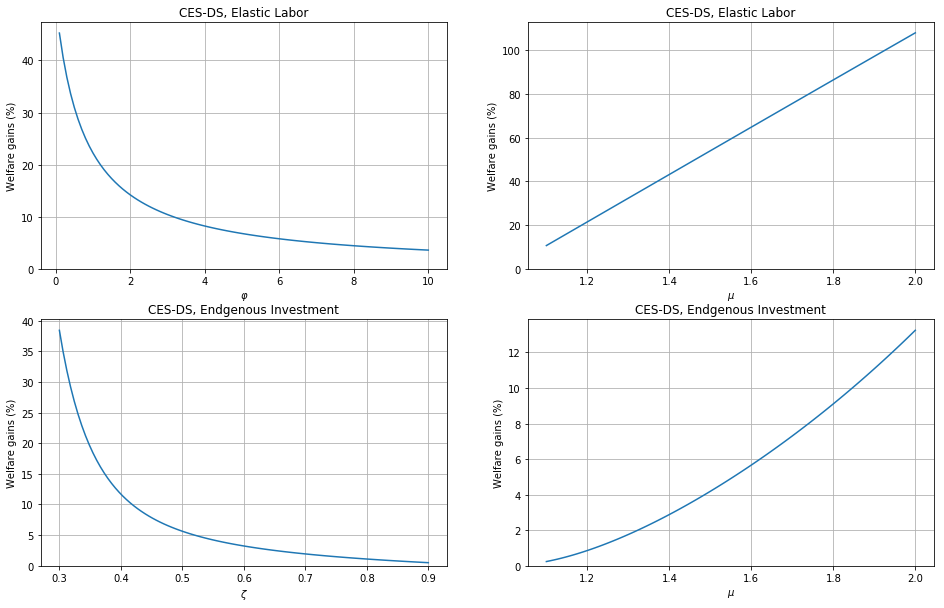

In [112]:
fig = plt.figure(figsize=(16,10))
plt.subplot(221)
plt.plot(df['cesds_EL1_varphi'],df['cesds_EL1_gain'])
plt.ylabel('Welfare gains (%)')
plt.xlabel("$\\varphi$")
yl = plt.ylim()
plt.ylim(0,yl[1])
plt.title("CES-DS, Elastic Labor")
plt.grid()
# xlim(4,8)
# ylim(0,0.2)
plt.subplot(222)
plt.plot(df['cesds_EL2_mu'],df['cesds_EL2_gain'])
plt.ylabel('Welfare gains (%)')
plt.xlabel("$\\mu$")
yl = plt.ylim()
plt.ylim(0,yl[1])
plt.title("CES-DS, Elastic Labor")
plt.grid()
# xlim(4,8)
# ylim(0,0.2)
plt.subplot(223)
plt.plot(df['cesds_EI1_zeta'],df['cesds_EI1_gain'])
plt.ylabel('Welfare gains (%)')
plt.xlabel("$\\zeta$")
yl = plt.ylim()
plt.ylim(0,yl[1])
plt.title("CES-DS, Endgenous Investment")
plt.grid()
# xlim(4,8)
# ylim(0,0.2)
plt.subplot(224)
plt.plot(df['cesds_EI2_mu'],df['cesds_EI2_gain'])
plt.ylabel('Welfare gains (%)')
plt.xlabel("$\\mu$")
yl = plt.ylim()
plt.ylim(0,yl[1])
plt.title("CES-DS, Endgenous Investment")
plt.grid()
# xlim(4,8)
# ylim(0,0.2)

plt.savefig('BGM_welfare_gains_2.png')
plt.savefig('BGM_welfare_gains_2.pdf')
plt.savefig('BGM_welfare_gains_2.svg')



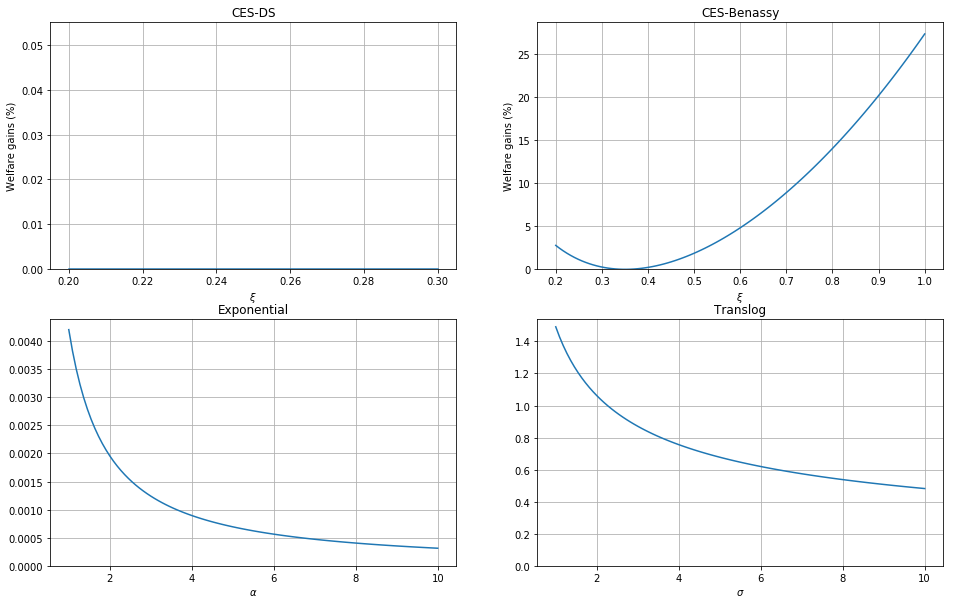

In [86]:
### Baseline model ###
fig = plt.figure(figsize=(16,10))
plt.subplot(221)
plt.plot(df['cesds_delta'],df['cesds_gain'])
plt.ylabel('Welfare gains (%)')
plt.xlabel("$\\xi$")
yl = plt.ylim()
plt.ylim(0,yl[1])
plt.title("CES-DS")
plt.grid()
# xlim(4,8)
# ylim(0,0.2)
plt.subplot(222)
plt.plot(df['ces_xi'],df['ces_gain'])
plt.ylabel('Welfare gains (%)')
plt.xlabel("$\\xi$")
yl = plt.ylim()
plt.ylim(0,yl[1])
plt.title("CES-Benassy")
plt.grid()
# xlim(4,8)
# ylim(0,0.2)
plt.subplot(223)
plt.plot(df['exponential_alpha'],df['exponential_gain'])
plt.grid()
yl = plt.ylim()
plt.ylim(0,yl[1])
plt.title("Exponential")
plt.xlabel("$\\alpha$")
plt.subplot(224)
plt.plot(df['translog_sigma'],df['translog_gain'])
plt.grid()
yl = plt.ylim()
plt.ylim(0,yl[1])
plt.title("Translog")
plt.xlabel("$\\sigma$")
plt.savefig('BGM_welfare_gains.png')
plt.savefig('BGM_welfare_gains.pdf')
plt.savefig('BGM_welfare_gains.svg')
